<a href="https://colab.research.google.com/github/ashwinigit123/DataMining/blob/main/Assignment3_Ashwini_AmazonData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1812]:
import pandas as pd
#open the text file that needs to be read and converted to CSV
#note: add the text file on drive to run
imdb_file = open(r"/content/drive/MyDrive/sentimentAnalysis/amazon_cells_labelled.txt", "r")
def convertTextToCSV(file):
    lines=file.readlines()
    file.close()
    rev_sentiments=[]
    for l in lines:
        x=l.split('\t')
        rev_sentiments.append([str.lstrip(str.rstrip(x[0])),str.lstrip(str.rstrip(x[1]))])
    return rev_sentiments

rs_list=convertTextToCSV(imdb_file)
review_sentiment_DF=pd.DataFrame(rs_list,columns=['REVIEW','SENTIMENT'])
review_sentiment_DF.to_csv('amazon.csv', index = None)
df = pd.read_csv('amazon.csv')
df.head()

,REVIEW,SENTIMENT
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [1813]:
df.describe()

,SENTIMENT
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


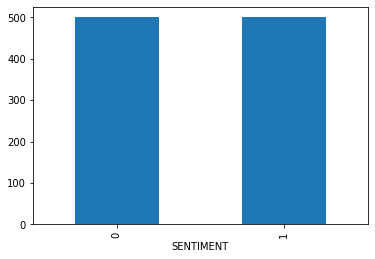

In [1814]:
import matplotlib.pyplot as plt

review_sentiment_DF.groupby('SENTIMENT').REVIEW.count().plot.bar(ylim=0)
plt.show()


In [1815]:
train_split = int(0.8 * len(df))
print(train_split)
dev_split = int(0.9 * len(df))
print(dev_split)
train_set = review_sentiment_DF[:train_split]
dev_set = review_sentiment_DF[train_split:dev_split]
test_set = review_sentiment_DF[dev_split:]

800
900


In [1816]:
train_set.head(5)

,REVIEW,SENTIMENT
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [1817]:
dev_set

,REVIEW,SENTIMENT
800,"Good , works fine.",1
801,For the price this was a great deal.,1
802,"Great price, too!",1
803,"If there is a wind, it is completely useless.",0
804,Yes it's shiny on front side - and I love it!,1
...,...,...
895,It was quite comfortable in the ear.,1
896,Great phone.,1
897,Don't buy this product - It fails!.,0
898,Everything about this product is wrong.First,0


In [1818]:
test_set

,REVIEW,SENTIMENT
900,"This was utterly confusing at first, which cau...",0
901,Terrible phone holder.,0
902,The cutouts and buttons are placed perfectly.,1
903,I love being able to use one headset for both ...,1
904,Problem is that the ear loops are made of weak...,0
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


In [1819]:
#Calculating the probability of any word in the given document.
def wordProbabiltity(data,word,numofDoc):
    data_dictionary=dict(data)
    if word in data_dictionary.keys():
        return data_dictionary[word] / numofDoc
    else: return 0

In [1820]:
from collections import Counter
#calculating the uniquewords and building the vocabulary by ommitting rare words(Words occuring less than 5 times)
def countUniqueWords(data):
    reviews = data
    vocab = []
    for review in reviews:
        for word in review.split(' '):
                vocab.append(word)
    vocab = Counter(vocab)
    vocab = Counter({k: v for k, v in vocab.items() if v > 5}) #removing rare word if occuring less than 5 times.
    return vocab


In [1821]:
uniqueWordcount = countUniqueWords(list(list(zip(*review_sentiment_DF.values))[0]))

In [1822]:
print("The P['the'] in the given number of documents: ",wordProbabiltity(uniqueWordcount,'the',len(review_sentiment_DF)))

The P['the'] in the given number of documents:  0.414


In [1823]:
print("The P['a'] in the given number of documents: ",wordProbabiltity(uniqueWordcount,'a',len(review_sentiment_DF)))

The P['a'] in the given number of documents:  0.207


In [1824]:
import numpy as np
#calculate the conditional Probability of given words based on sentiments
def calulateConditionalProbabilty(A,B,word,givenSentiment):
    #Grouping the Similar sentiments together 
    sentimentGroup = np.unique(B)
    dictionary = dict()
    #creating a dictionary of of sentiments.
    for sentiment in sentimentGroup:
        dictionary[sentiment] = A[np.where(B == sentiment)]

    #Counting postive words and negative words
    countPostivewords = dict(countUniqueWords(dictionary['1']))
    countNegativeWords = dict(countUniqueWords(dictionary['0']))
    
    #caculating the probabilty for the given sentiment
    if givenSentiment == '1':
        if word in countPostivewords.keys():
            return countPostivewords[word]/ len(dictionary['1'])
        else: return 0
    else:
        if word in countNegativeWords.keys():
            return countNegativeWords[word]/ len(dictionary['0'])
        else: return 0


In [1825]:
#caculating the conditional probability for the given sentiment is 1.
A = train_set['REVIEW'].values
B = train_set['SENTIMENT'].values

print(" The P['the'|positive] is:", calulateConditionalProbabilty(A,B,'the','1'))


 The P['the'|positive] is: 0.38141809290953543


In [1826]:
#Calculating the probability of each sentiment
def probabilityOfSentiment(sentiment,dataset):
  return list(dataset).count(sentiment) / len(list(dataset))

In [1827]:
#defining the naive bayes classifer
class NaiveBayes:
    def __init__(self,X,y,test,alpha,flag):
        self.alpha = alpha
        self.X = X
        self.y = y
        self.test = test
        self.sentiment = np.unique(y)
        self.flag = flag
        
    def naiveBayesAlgo(self,word,sentiment):
        probWordGivenSentiment = calulateConditionalProbabilty(self.X,self.y,word,sentiment)
        
        probOfSentiment = probabilityOfSentiment(sentiment,self.y)
        
        countUniqueWordsInDataset = countUniqueWords(list(self.X))
        probOfWordOccur = wordProbabiltity(countUniqueWordsInDataset,word,len(self.X))
        
        if probOfWordOccur == 0:
            probOfWordOccur = 0.0000001
        if self.alpha == 0:
            return (probWordGivenSentiment*probOfSentiment)/probOfWordOccur  #withouth smoothing
        else:
            if word in self.wordcount.keys():
                count = self.wordcount[word]
            else: count = 1
            return ((probWordGivenSentiment*probOfSentiment) + self.alpha) / (probOfWordOccur + count) #with smoothing
        
        
    def NaiveBayespredict(self):
        result = 1
        y_pred = []
        positive = 0
        negative = 0
        self.separated = dict()
        posdict = dict()
        negdict = dict()
        
        self.wordcount = dict(countUniqueWords(self.X)) #vocab list
        
        for i in self.sentiment:
            self.separated[i] = self.X[np.where(self.y == i)] 
        self.countpos = dict(countUniqueWords(self.separated['1']))
        self.countneg = dict(countUniqueWords(self.separated['0']))
        
        if self.flag != True:
            for review in self.test:
                for senti in self.sentiment:
                    for word in review.split():
                        prob = self.naiveBayesAlgo(word,senti)
                        result = result * prob
                    if senti == 1:
                        positive = result
                    else:
                        negative = result

                if positive > negative:
                    y_pred.append('1')
                else: y_pred.append('0')

            return y_pred
        else:
            for word in self.countpos.keys(): 
                prob = self.naiveBayesAlgo(word,'1')
                posdict[word] = prob
            for word in self.countneg.keys(): 
                prob = self.naiveBayesAlgo(word,'0')
                negdict[word] = prob
            return posdict,negdict

In [1828]:
def calculateAccuracy(actual,predicted):
    correctPredict = 0.0
    for y_true, y_pred in zip(actual,predicted):
        if y_true == y_pred:
            correctPredict += 1
    return correctPredict / float(len(actual)) * 100.0

In [1829]:
def cross_valid(data,k,alpha):
    devsize = 1/k
    score = []
    for i in range(1, k + 1):
        devdata = data.sample(frac=devsize, random_state=i, replace=False).copy(deep=True)
        traindata = data.drop(devdata.index, axis=0).copy(deep=True)
        X_dev = devdata['REVIEW'].values
        y_dev = devdata['SENTIMENT'].values
        X_train = traindata['REVIEW'].values
        y_train = traindata['SENTIMENT'].values
        classifer = NaiveBayes(X_train,y_train,X_dev,alpha,flag= False)
        ypred = np.array(classifer.NaiveBayespredict())
        score.append(calculateAccuracy(y_dev,ypred))
    return score

In [1830]:
X_train = train_set['REVIEW'].values
y_train = train_set['SENTIMENT'].values
X_dev = dev_set['REVIEW'].values
y_dev = dev_set['SENTIMENT'].values
classifer = NaiveBayes(X_train,y_train,X_dev,0,0)
ypred = classifer.NaiveBayespredict()
ypred = np.array(ypred)
print("Accuracy on the dev Dataset without smoothing is:",calculateAccuracy(y_dev,ypred))

Accuracy on the dev Dataset without smoothing is: 51.0


In [1831]:
score = cross_valid(train_set,5,1)
print("Accuracy on dev data with smoothing with alpha 1 : {} %".format(np.mean(score)))

Accuracy on dev data with smoothing with alpha 1 : 49.25 %


In [1832]:
score2 = cross_valid(train_set,5,0.001)
print("Accuracy on dev data with smoothing with alpha 0.001 : {} %".format(np.mean(score2)))

Accuracy on dev data with smoothing with alpha 0.001 : 49.25 %


In [1833]:
positive=dict()
wrodcount = dict(uniqueWordcount)
classifer = NaiveBayes(X_train,y_train,0,1,flag=True)
pos, neg = classifer.NaiveBayespredict()

In [1834]:
pos

{'-': 0.05335435968197647,
 '2': 0.06296816479400749,
 'Battery': 0.10074906367041199,
 'Excellent': 0.10099875156054931,
 'Good': 0.11222083506727701,
 'Great': 0.0382392379895501,
 'I': 0.004711189202796915,
 "I'm": 0.07196361690743713,
 "I've": 0.03927782579467973,
 'It': 0.02401068431901983,
 'Nice': 0.12609238451935081,
 'The': 0.012758442191163484,
 'This': 0.023026772090442505,
 'Very': 0.07214196540039236,
 'Works': 0.09204403586426058,
 'a': 0.006576600677724273,
 'all': 0.04412962058296695,
 'also': 0.09147656338667576,
 'am': 0.059484467944481166,
 'an': 0.06716604244694133,
 'and': 0.004807498691152189,
 'any': 0.06335830212234707,
 'are': 0.030946165777626454,
 'as': 0.029177813447476365,
 'at': 0.059337592714988625,
 'battery': 0.04407534060685013,
 'be': 0.048035194102609834,
 'because': 0.07749927974647076,
 'been': 0.09181704687322664,
 'best': 0.08447773616312941,
 'but': 0.02826328200860036,
 'camera': 0.12578027465667915,
 'can': 0.08395755305867665,
 'car': 0.08385

In [1835]:
neg

{'-': 0.053025822984427366,
 '2': 0.06312421972534332,
 'A': 0.1118046885837148,
 "Don't": 0.11222083506727701,
 'I': 0.004757427700970494,
 "I'm": 0.07196361690743713,
 "I've": 0.03879765677518487,
 'If': 0.10099875156054931,
 'It': 0.02369131608744883,
 'NOT': 0.12609238451935081,
 'Not': 0.11208211957275627,
 'The': 0.012849791419262506,
 'This': 0.02261062560688029,
 'a': 0.006561738303311337,
 'about': 0.07214196540039236,
 'after': 0.06749895963379109,
 'all': 0.04396678065461651,
 'am': 0.059264155100242355,
 'an': 0.06724927174365376,
 'and': 0.0044953888284805284,
 'are': 0.030832671282109488,
 'as': 0.02914214374888532,
 'at': 0.059411030329734896,
 'bad': 0.1677070328755722,
 'battery': 0.04402106063073332,
 'be': 0.04833244159086856,
 'because': 0.0774032459425718,
 'better': 0.09159005788219272,
 'bought': 0.09147656338667576,
 'but': 0.02847135525038147,
 'buy': 0.10087390761548065,
 'by': 0.1677070328755722,
 'car': 0.0838535164377861,
 'case': 0.0838535164377861,
 'char

In [1836]:
df_pos = pd.DataFrame.from_dict(pos, orient='index')
df_neg = pd.DataFrame.from_dict(neg, orient='index')

In [1837]:
df_pos.sort_values(by=0,ascending=False).head(10)

,0
excellent,0.167707
fine,0.167707
case.,0.167707
pretty,0.167707
device,0.143749
wear,0.143749
years,0.143749
Nice,0.126092
price.,0.126092
highly,0.125936


In [1838]:
df_neg.sort_values(by=0,ascending=False).head(10)

,0
difficult,0.167707
bad,0.167707
by,0.167707
unit,0.143927
money,0.143927
NOT,0.126092
waste,0.126092
thing,0.125936
right,0.125780
Don't,0.112221


In [1839]:
testscore = cross_valid(test_set,5,1)
print("Accuracy on test data with smoothing with alpha 1 : {} %".format(np.mean(testscore)))

Accuracy on test data with smoothing with alpha 1 : 56.0 %
